# Data Loading

In [37]:
import pandas as pd

Loading dataset on which we are applying transfer learning.

In [38]:
data = pd.read_csv(r'raw_data.csv')
data.head()

,Sno,Date,Headline,Covid,Sentiment,Description,Image,Source
0,0,2020-04-29,"Coronavirus cases reach 2,438 in Rajasthan; 81...",1,0,Rajasthan on Wednesday reported 74 new coronav...,https://static.inshorts.com/inshorts/images/v1...,http://www.rajswasthya.nic.in/?utm_campaign=fu...
1,1,2020-04-29,"Coronavirus cases in Delhi surge to 3,439 afte...",1,0,The total number of coronavirus cases in Delhi...,https://static.inshorts.com/inshorts/images/v1...,https://twitter.com/shemin_joy/status/12555489...
2,2,2020-04-30,"Anguished, I'll always recall our interactions...",0,1,"Condoling the demise of actor Rishi Kapoor, PM...",https://static.inshorts.com/inshorts/images/v1...,https://twitter.com/narendramodi/status/125573...
3,3,2020-04-30,It's a terrible week for Indian cinema: Rahul ...,0,0,Congress leader Rahul Gandhi condoled Rishi Ka...,https://static.inshorts.com/inshorts/images/v1...,https://zeenews.india.com/india/politicians-mo...
4,4,2020-04-30,Delhi Police perform 'parikrama' of AIIMS to t...,1,1,As a sign of respect for healthcare profession...,https://static.inshorts.com/inshorts/images/v1...,https://zeenews.india.com/india/delhi-police-p...


We are only interested in the Headline and Sentiment columns.

Removing unnecessary columns from data.

In [39]:
data.drop(columns = ['Sno', 'Date', 'Covid', 'Description', 'Image', 'Source'], inplace = True)
data.head()

,Headline,Sentiment
0,"Coronavirus cases reach 2,438 in Rajasthan; 81...",0
1,"Coronavirus cases in Delhi surge to 3,439 afte...",0
2,"Anguished, I'll always recall our interactions...",1
3,It's a terrible week for Indian cinema: Rahul ...,0
4,Delhi Police perform 'parikrama' of AIIMS to t...,1


Make sure that there are no NULL values.

If NULL values are present, perform data cleaning to make sure consistency in data. Missing values can lead to skew results and in turn reduce accuracy of models.

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headline   4072 non-null   object
 1   Sentiment  4072 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.8+ KB


Since there are no Null values we are can go to ahead with data preprocessing

# EDA

It is always a good idea to make yourself familiar with the data you're going to use for modelling. This will give you an idea on what you can and cannot do with the data you have.

In [41]:
import matplotlib.pyplot as plt

In [42]:
data['Sentiment'] = data['Sentiment'].map({0:'Negative', 1:'Positive'})
data.head()

,Headline,Sentiment
0,"Coronavirus cases reach 2,438 in Rajasthan; 81...",Negative
1,"Coronavirus cases in Delhi surge to 3,439 afte...",Negative
2,"Anguished, I'll always recall our interactions...",Positive
3,It's a terrible week for Indian cinema: Rahul ...,Negative
4,Delhi Police perform 'parikrama' of AIIMS to t...,Positive


Checking the distribution of positive and negative values

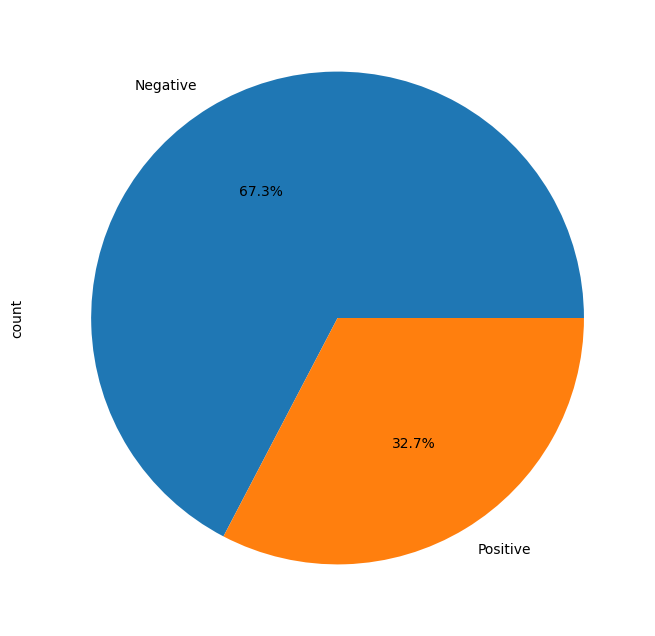

In [43]:
plt.figure(figsize = (8, 8))
data['Sentiment'].value_counts().plot.pie(autopct = '%1.1f%%')
plt.show()

Clearly the data is skewwed towards negative. This shows that there is a class imbalance.

We need to keep in mind when we start building our models.

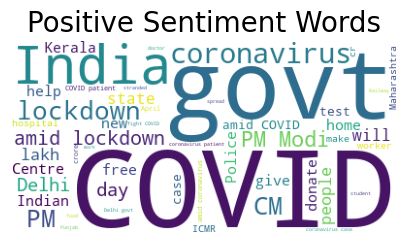

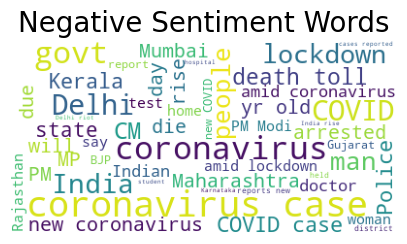

In [44]:
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - data: news dataset
       - category: Positive/Negative
    '''
    # Combine all tweets
    combined_tweets = ' '.join(df[df['Sentiment'] == category]['Headline'])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(5,5))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(data, 'Positive')
     
# Negative tweet words
wordcount_gen(data, 'Negative')

WordCloud is used to give a visual representation of text data where the size of each word indicates its frequency or importance within the dataset. 

# Data preprocessing

Data preprocessing involves transforming raw data, obtained after the data loading step, into a clean and structured format suitable for use in models. This step is crucial to ensure that the data is accurate, consistent, and ready for analysis.

In [45]:
import numpy as np
from copy import deepcopy
from nltk.corpus import stopwords
from textblob import Word
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split 

In [46]:
X = data.drop('Sentiment', axis = 1)
y = data['Sentiment'].map({'Negative':0, 'Positive':1})

Tranforming text in Headline column into a standardized format which is more suitable for our model.

Here is what each part does:
1. Deep Copy: Creates a deep copy of the input data to avoid modifying the original DataFrame.
2. Lowercasing: Converts all characters in the 'Headline' column to lowercase.
3. Replacing Digits/Numbers: Removes all digits/numbers from the text in the 'Headline' column.
4. Removing Special Characters: Removes special characters (non-alphanumeric characters) from the text in the 'Headline' column.
5. Removing Stop Words: Removes common stop words (e.g., "and", "the", "is") from the text in the 'Headline' column.
6. Lemmatization: Converts words in the 'Headline' column to their base or root form. Used to standardize words so that variations of the same word are treated as the same entity. e.g., "running" to "run".



In [47]:
def cleaning(data, stop_words):
    df = deepcopy(data)
    # Lower case
    df['Headline'] = df['Headline'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
    # Replacing the digits/numbers
    df['Headline'] = df['Headline'].str.replace(r'\d+','', regex=True)
    # Removing special characters
    df['Headline'] = df['Headline'].str.replace(r'[^\w\s]','', regex=True)
    # Removing stop words
    df['Headline'] = df['Headline'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    df['Headline'] = df['Headline'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))
    return df
stop_words = stopwords.words('english')
corpus = cleaning(X, stop_words)
print(corpus.head())

                                            Headline
0   coronavirus case reach rajasthan patient recover
1  coronavirus case delhi surge new case reported...
2  anguished ill always recall interaction pm mod...
3  terrible week indian cinema rahul gandhi rishi...
4  delhi police perform parikrama aiims thank med...


We furthur convert this data into it's one-hot representation.
Converting text data to one-hot representation is a crucial step in preparing text data for various NLP tasks, enabling the application of machine learning models to analyze and extract insights from textual information.

In [48]:
vocab_size = 5000

onehot_repr = [one_hot(words, vocab_size) for words in corpus['Headline']]
print(onehot_repr[:5])

[[4305, 919, 4694, 621, 938, 4804], [4305, 919, 3167, 2043, 4213, 919, 1383, 21], [3293, 4540, 2809, 3170, 2383, 4856, 3904, 1323, 4731, 3071], [4657, 1452, 1517, 90, 3134, 3592, 1323, 4731, 4164], [3167, 4500, 2290, 1415, 3419, 3816, 1969, 1104]]


Clearly the shape is not consistent, hence we need to apply padding to ensure the one-hot encoded words have the same length.
This is necessary for batch processing and efficient computation in neural network.

In [49]:
embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = 20)
print(embedded_docs[:5])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  4305  919 4694  621  938 4804]
 [   0    0    0    0    0    0    0    0    0    0    0    0 4305  919
  3167 2043 4213  919 1383   21]
 [   0    0    0    0    0    0    0    0    0    0 3293 4540 2809 3170
  2383 4856 3904 1323 4731 3071]
 [   0    0    0    0    0    0    0    0    0    0    0 4657 1452 1517
    90 3134 3592 1323 4731 4164]
 [   0    0    0    0    0    0    0    0    0    0    0    0 3167 4500
  2290 1415 3419 3816 1969 1104]]


Finally we spit the data which we are going to use for train and test.

In [50]:
# Splitting the dataset

X = np.array(embedded_docs)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)

(3257, 20) (3257,)


# Model

Since the data suggests that we need a classification model(sentiment is either 0 or 1) we'll be first testing out a simple logistic regression. Then we'll try out a couple of RNN models(LSTM and Bidirectional LSTM).

In [51]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional

## Logistic Regression

If you recall, the data we have is imbalanced, that is, skewwed towards negative.
This is have a very bad effect on the Logistic Regression model.
Therefore we need to make the data balanced using SMOTE(Synthetic Minority Over-sampling Technique).
It is a technique used in machine learning to address class imbalance in datasets, particularly in classification tasks.

In [52]:
# Check class distribution
print("Class distribution in y_train:")
print(pd.Series(y_train).value_counts())

print("Class distribution in y_test:")
print(pd.Series(y_test).value_counts())

# Making the data balanced
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution
print("Class distribution in y_resampled:")
print(pd.Series(y_resampled).value_counts())

Class distribution in y_train:
0    2177
1    1080
Name: count, dtype: int64
Class distribution in y_test:
0    565
1    250
Name: count, dtype: int64
Class distribution in y_resampled:
0    2177
1    2177
Name: count, dtype: int64


In [53]:
# Fit the classifier
classifier = LogisticRegression()
classifier.fit(X_resampled, y_resampled)

# Predict
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", accuracy)

Accuracy:  0.501840490797546


c:\Users\Pranaav_Prasad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## LSTM

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture. LSTMs are powerful models commonly used for sequence prediction and sequence classification tasks in natural language processing (NLP), time series analysis, and other domains where sequential data is prevalent.

In [54]:
# LSTM Model

model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, 40, input_length = 20))
model_LSTM.add(SpatialDropout1D(0.4))
model_LSTM.add(LSTM(200, dropout = 0.2, recurrent_dropout = 0.2))
model_LSTM.add(Dense(100, activation = 'leaky_relu'))
model_LSTM.add(Dense(1, activation = 'sigmoid'))
model_LSTM.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

c:\Users\Pranaav_Prasad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [55]:
history_LSTM = model_LSTM.fit(X_train, y_train, validation_data =(X_test, y_test) , epochs = 10, batch_size = 64, verbose=1)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6391 - loss: 0.6502 - val_accuracy: 0.6945 - val_loss: 0.5787
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7313 - loss: 0.5194 - val_accuracy: 0.7926 - val_loss: 0.4508
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8539 - loss: 0.3426 - val_accuracy: 0.7816 - val_loss: 0.5079
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8969 - loss: 0.2529 - val_accuracy: 0.7828 - val_loss: 0.5282
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9201 - loss: 0.1982 - val_accuracy: 0.7902 - val_loss: 0.5198
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9397 - loss: 0.1686 - val_accuracy: 0.7840 - val_loss: 0.6212
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9541 - loss: 0.1270 - val_accuracy: 0.7755 - val_loss: 0.6432
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9677 - loss: 0.0957 - val_accuracy: 0.7840 - v

## Bidirectional LSTM

A Bidirectional Long Short-Term Memory (BiLSTM) model is an extension of the traditional Long Short-Term Memory (LSTM) architecture. In a standard LSTM, information flows only from past to future, which means the model can only consider past context when making predictions. In contrast, a BiLSTM model processes input sequences in both forward and backward directions simultaneously, allowing it to capture information from both past and future contexts.

In [56]:
# Bidirectional LSTM Model

model_BiLSTM = Sequential()
model_BiLSTM.add(Embedding(vocab_size, 40, input_length = 20))
model_BiLSTM.add(SpatialDropout1D(0.4))
model_BiLSTM.add(Bidirectional(LSTM(200, dropout = 0.2, recurrent_dropout = 0.2)))
model_BiLSTM.add(Dense(100, activation = 'leaky_relu'))
model_BiLSTM.add(Dense(1, activation = 'sigmoid'))
model_BiLSTM.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [57]:
history_BiLSTM = model_BiLSTM.fit(X_train, y_train, validation_data =(X_test, y_test) , epochs = 10, batch_size = 64, verbose=1)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6394 - loss: 0.6479 - val_accuracy: 0.6933 - val_loss: 0.5623
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7483 - loss: 0.4900 - val_accuracy: 0.7914 - val_loss: 0.4427
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8515 - loss: 0.3364 - val_accuracy: 0.8049 - val_loss: 0.4845
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8823 - loss: 0.2653 - val_accuracy: 0.7902 - val_loss: 0.4938
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9335 - loss: 0.1824 - val_accuracy: 0.7926 - val_loss: 0.5272
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9507 - loss: 0.1457 - val_accuracy: 0.7902 - val_loss: 0.6213
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9647 - loss: 0.1061 - val_accuracy: 0.7840 - val_loss: 0.6462
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9682 - loss: 0.0983 - val_accuracy: 0.7755 - v

# Performance metrics and Accuracy

In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Let's compare the three models we trained.

In [59]:
y_pred_LR = classifier.predict(X_test)

confusion_matrix_LR = confusion_matrix(y_test, y_pred_LR)
accuracy_LR = accuracy_score(y_test, y_pred_LR)
precision_LR = precision_score(y_test, y_pred_LR)
recall_LR = recall_score(y_test, y_pred_LR)
f1_LR = f1_score(y_test, y_pred_LR)

print("Confusion Matrix: \n", confusion_matrix_LR)
print("Accuracy: ", accuracy_LR)
print("Precision: ", precision_LR)
print("Recall: ", recall_LR)
print("F1 Score: ", f1_LR)

Confusion Matrix: 
 [[272 293]
 [113 137]]
Accuracy:  0.501840490797546
Precision:  0.3186046511627907
Recall:  0.548
F1 Score:  0.40294117647058825


In [60]:
y_pred_LSTM = model_LSTM.predict(X_test)

confusion_matrix_LSTM = confusion_matrix(y_test, y_pred_LSTM.round())
accuracy_LSTM = accuracy_score(y_test, y_pred_LSTM.round())
precision_LSTM = precision_score(y_test, y_pred_LSTM.round())
recall_LSTM = recall_score(y_test, y_pred_LSTM.round())
f1_LSTM = f1_score(y_test, y_pred_LSTM.round())

print("Confusion Matrix for LSTM: \n", confusion_matrix_LSTM)
print("Accuracy for LSTM: ", accuracy_LSTM)
print("Precision for LSTM: ", precision_LSTM)
print("Recall for LSTM: ", recall_LSTM)
print("F1 Score for LSTM: ", f1_LSTM)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Confusion Matrix for LSTM: 
 [[466  99]
 [ 85 165]]
Accuracy for LSTM:  0.7742331288343558
Precision for LSTM:  0.625
Recall for LSTM:  0.66
F1 Score for LSTM:  0.642023346303502


In [61]:
y_pred_BiLSTM = model_BiLSTM.predict(X_test)

confusion_matrix_BiLSTM = confusion_matrix(y_test, y_pred_BiLSTM.round())
accuracy_BiLSTM = accuracy_score(y_test, y_pred_BiLSTM.round())
precision_BiLSTM = precision_score(y_test, y_pred_BiLSTM.round())
recall_BiLSTM = recall_score(y_test, y_pred_BiLSTM.round())
f1_BiLSTM = f1_score(y_test, y_pred_BiLSTM.round())

print("Confusion Matrix for BiLSTM: \n", confusion_matrix_BiLSTM)
print("Accuracy for BiLSTM: ", accuracy_BiLSTM)
print("Precision for BiLSTM: ", precision_BiLSTM)
print("Recall for BiLSTM: ", recall_BiLSTM)
print("F1 Score for BiLSTM: ", f1_BiLSTM)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Confusion Matrix for BiLSTM: 
 [[471  94]
 [ 85 165]]
Accuracy for BiLSTM:  0.7803680981595092
Precision for BiLSTM:  0.637065637065637
Recall for BiLSTM:  0.66
F1 Score for BiLSTM:  0.6483300589390962


Clearly, our RNN models do better than the traditional Logistic Regression model.

To get a better idea how our two RNN compare with each other, let's visualize!

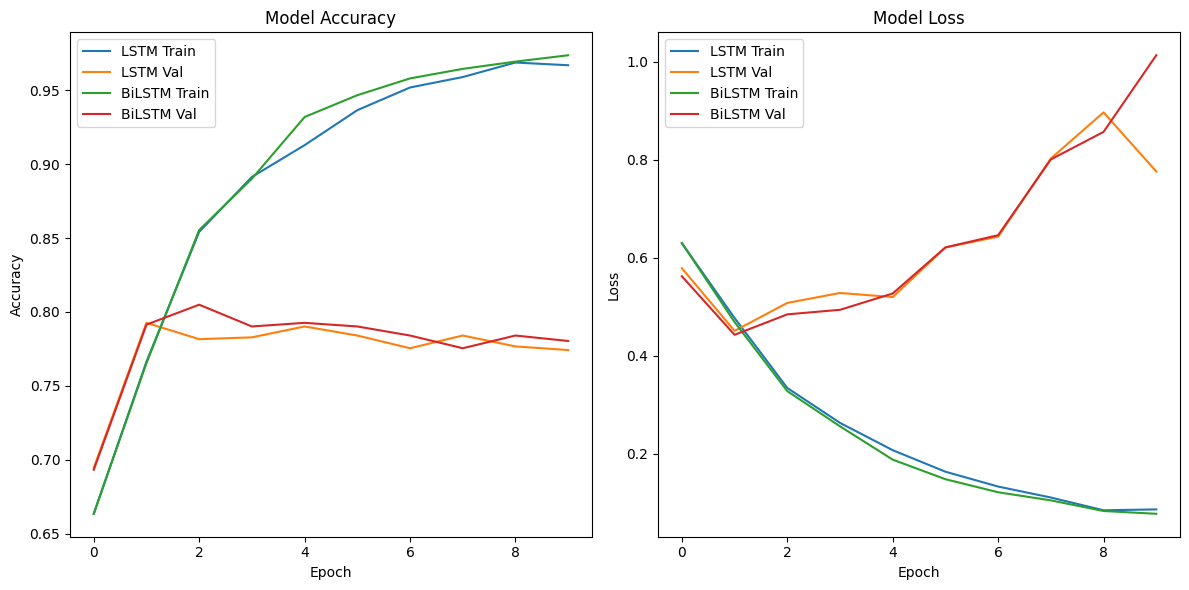

In [62]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.plot(history_BiLSTM.history['accuracy'])
plt.plot(history_BiLSTM.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LSTM Train', 'LSTM Val', 'BiLSTM Train', 'BiLSTM Val'], loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.plot(history_BiLSTM.history['loss'])
plt.plot(history_BiLSTM.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['LSTM Train', 'LSTM Val', 'BiLSTM Train', 'BiLSTM Val'], loc='upper left')

plt.tight_layout()
plt.show()

# Recommender

Now coming to our actual Recommender System. We used the models we trained above to classify the latest news headlines as positive and negative.

In [63]:
import pandas as pd

In [78]:
news = pd.read_csv(r'india-news-headlines.csv')
news.head()

,headline_text
0,Status quo will not be disturbed at Ayodhya; says Vajpayee
1,Fissures in Hurriyat over Pak visit
2,America's unwanted heading for India?
3,For bigwigs; it is destination Goa
4,Extra buses to clear tourist traffic


In [80]:
news.rename(columns = {'headline_text':'Headline'}, inplace = True)
news.head()

,Headline
0,Status quo will not be disturbed at Ayodhya; says Vajpayee
1,Fissures in Hurriyat over Pak visit
2,America's unwanted heading for India?
3,For bigwigs; it is destination Goa
4,Extra buses to clear tourist traffic


Transforming headlines similar to data that the model was trained on to get valid results.

In [81]:
news_cleaned = cleaning(news, stop_words)
onehot_news_cleaned = [one_hot(words, vocab_size) for words in news_cleaned['Headline']]
embedded_news = pad_sequences(onehot_news_cleaned, padding = 'pre', maxlen = 20)

In [82]:
pred = model_LSTM.predict(embedded_news).round().astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [88]:
pd.set_option('display.max_colwidth', None)
positive_news = news.loc[pred == 1, 'Headline'].sample(10)
print("Positive News Headlines:\n", positive_news)

Positive News Headlines:
 411                       Guala Closures bags ISO 9002 certificate
659                         Wockhardt plans another cardiac centre
651                                               Straight Answers
417    Australia; New Zealand urged to accept Indo-Fijian refugees
18                           Hoshangabad farmers have enough water
831                            Soccer helps heal the wounds of war
689                          Net familiarity will drive e-commerce
452                       Are green activists the new imperialists
269                         An art gallery for the underprivileged
367    Australia; New Zealand urged to accept Indo-Fijian refugees
Name: Headline, dtype: object


Finally we get the positive news which we can be recommended to users.